In [153]:
# Numerical
from jax.numpy import exp, newaxis, mean   # Arithematic
from jax.numpy import array, zeros, arange, where # Array creation routines
from jax.numpy import float64
from jax.numpy import sum as vsum
from jax.numpy.linalg import solve, eig, norm
from jax.random import PRNGKey
from jax import jit, jacrev, jacfwd, vmap, grad, jvp, vjp

# Miscellaneous
from functools import partial 
from ticktack import load_presaved_model

# Hamiltonian monte-carlo
from numpyro.infer import NUTS, MCMC

# Visualisation
import matplotlib.pyplot as plt

In [138]:
def construct_analytic_solution():
    """
    This creates a closure environment that pre-calculates the eigenvalues of the transfer matrix and the coefficients that produce the approriate initial state.
    """
    cbm = load_presaved_model("Guttler14", production_rate_units="atoms/cm^2/s")
    cbm.compile()
    # So I actually want to get rid of this and dynamically generate the cbm. 
    # Alternatively, I could use the guttler14 as a base and add the variation 
    # Through the addition of a variation matrix. 

    eigenvalues, eigenvectors = eig(cbm._matrix)    # Constructing the linear eigenfunctions
    eigenvalues = eigenvalues.real  # Making sure that values are real
    eigenvectors = eigenvectors.real    # Making sure that the eigenvectors are real 

    soln = solve(eigenvectors, cbm._production_coefficients)
    soln = 1 / norm(soln) * soln    # Normalising the impulse 
    soln = soln.real

    @partial(jit, static_argnums=(3, 4, 5))
    def analytic_solution(time, start, area, coeffs=soln, eigenvals=eigenvalues, eigenvecs=eigenvectors):
        """
        This is the analytic solution itself.
        
        Parameters: 
            time: Array -> The time values that the solution is to be evaluated at 
            coeffs: Array -> The coefficients associated with a particular initial condition. 
          
            eigenvals: Array -> The eigenvalues of the transfer matrix used to construct the linear superposition of the eigenfunctions
            eigenvecs: Array[Array] -> The eigenvectors of the transfer matrix used to construct the linear superposition of the eigenfunctions.
        
        Returns:
            Array -> The analytic solution evaluated at times
        """
        @jit
        def sum_util(coeff, eigenval, eigenvec, /, time=time, start=start, area=area):
            return area * coeff * exp(eigenval * (time - start))[:, newaxis] * eigenvec

        impulse = vsum(vmap(sum_util)(coeffs, eigenvals, eigenvecs.T), axis=0)
        return where(time.reshape(time.shape[0], 1) > start, impulse, zeros(impulse.shape))

    return analytic_solution

In [139]:
@partial(jit, static_argnums=(0))
def load(filename: str):
    """
    A custom `JAX` file loading protocol designed to be very quick and return a value that is `JAX` transformable. 
    
    Parameters:
        filename: String -> The file address of the data
    Returns:
        DeviceArray -> The data in column major order
    """
    with open(filename) as data:    # Opening the data file
        header = next(data)
        data = array([row.strip().split(" ") for row in data], dtype=float64)
        return data.T


In [140]:
analytic_solution = construct_analytic_solution()
data = load("miyake12.csv")
data = data.at[1].add(-mean(data[1, 1:4]))

In [141]:
def construct_loss(analytic_solution=analytic_solution, data=data):
    @jit
    def loss(parameters):
        start, area = parameters
        analytic_data = analytic_solution(data[0], start, area)
        return vsum((data[1] - analytic_data[:, 1]) ** 2 / data[2] ** 2)
    
    return loss

In [142]:
# Autodiff declarations for the model
loss = construct_loss()
gradient = jit(grad(loss))
hessian = jit(jacfwd(grad(loss)))

In [149]:
# Running the No U Turn sampling
nuts_kernel = NUTS(potential_fn=loss)
mcmc = MCMC(nuts_kernel, num_warmup=100, num_samples=500, progress_bar=False)
mcmc.run(random.PRNGKey(11), init_params=(774.86, 80.0))

In [150]:
test = mcmc.get_samples()

In [151]:
import seaborn as sns

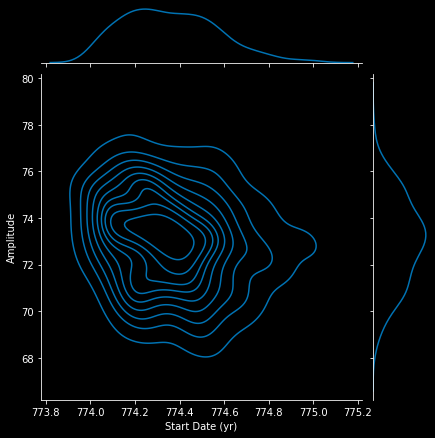

In [152]:
posterior_plot = sns.jointplot(x=test[0], y=test[1], kind="kde")
posterior_plot.set_axis_labels("Start Date (yr)", "Amplitude")

So I need to work out how to create a valid cbm transfer matrix with as the same number of parameters as dimensions.

In [155]:
cbm = load_presaved_model("Guttler14", production_rate_units="atoms/cm^2/s")
cbm.compile()

In [157]:
[[0 if i == 0 else 1 for i in j] for j in cbm._matrix]

[[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1],
 [0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0],
 [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
 [0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1]]

In [163]:
[[round(i, 2) for i in j] for j in cbm._matrix]

[[-0.51, 0.09, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.51, -0.44, 0.07, 0.0, 0.0, 0.55, 0.0, 0.17, 0.0, 0.0, 0.0],
 [0.0, 0.12, -0.16, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.04, -13.33, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.04, 1.33, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.23, 0.0, 0.0, 0.0, -1.05, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.14, -0.03, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.36, 0.03, -0.18, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, -0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0]]

In [165]:
[[1 if abs(i) > 1 else 0 for i in j] for j in cbm._matrix]

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]